# Solar Mapping

This application will analyze above ground features from DSMs to determine relative rate of direct insolation. 

![Where is the sun?](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/solar.jpg)    
*Where is the sun?*

In [55]:
################ DO NOT EDIT ################ 
# 
# Import ArcGIS package
#
import arcpy

# Subprocess allows us to issue commands on the command line
import subprocess
# Get current local time
import datetime
# Download utility
import urllib.request

# Function to print when cell finishing running.
def printComplete():
    print("Cell finished processing", datetime.datetime.now())

# Function definitions
def showStats(layer):
    """Function to calculate summary statistics on an integer raster attribute table.
    showStats(layer)
    One argument:
        layer = name of integer raster (ArcPy raster object)
    """
    lookup = {
        0: 'false',
        1: 'true',
        11:'Open Water',
        12:'Perennial Ice/Snow',
        21: 'Developed, Open Space',
        22: 'Developed, Low Intensity',
        23: 'Developed, Medium Intensity',
        24: 'Developed, High Intensity',
        31: 'Barren Land (Rock/Sand/Clay)',
        41: 'Deciduous Forest',
        42: 'Evergreen Forest',
        43: 'Mixed Forest',
        51: 'Dwarf Scrub',
        52: 'Shrub/Scrub',
        71: 'Grassland/Herbaceous',
        72: 'Sedge/Herbaceous',
        73: 'Lichens',
        74: 'Moss',
        81: 'Pasture/Hay',
        82: 'Cultivated Crops',
        90: 'Woody Wetlands',
        95: 'Emergent Herbaceous Wetlands',
    }
    desc = arcpy.Describe(layer)
    y, x = desc.meanCellHeight, desc.meanCellWidth
    codes = arcpy.SearchCursor(layer, "", "", "VALUE; COUNT")
    table = []
    total = 0
    for r in codes:
        v = r.getValue("VALUE")
        c = (r.getValue("COUNT") * (x * y))/43560
        total += round(c, 2)
        table.append([lookup[v], round(c, 2)])
    for r in table:
        percent = round((r[1]/total) * 100, 3)
        f = f'{r[0]}: {r[1]} ac and {percent}% of total'
        print (f)
        
def setUpProject():
    """Function to create project folder and database in root GIS.
    setUpProject()
    No arguments
    """
    filepath = f'{root}\\{project}'
    subprocess.run(f'mkdir {filepath}', shell=True)
    if arcpy.Exists(f'{filepath}\\{workspace}'):
        print(f'{filepath}\\{workspace} exists!')
    else:
        print(f"Creating {filepath}\\{workspace}")
        arcpy.CreateFileGDB_management(filepath, workspace)
    arcpy.env.workspace = f'{filepath}\\{workspace}'
    completed = subprocess.run(f'dir {filepath}', shell=True, stdout=subprocess.PIPE)
    print(completed.stdout.decode('UTF-8'))
    
def listLayers():
    """Function to list vector and raster layers in workspace
    listLayers()
    No arguments
    """
    rasters = arcpy.ListRasters()
    features = arcpy.ListFeatureClasses()
    print(rasters, features)
#     for raster in rasters:
#         getRasterProps(raster)
#     for feature in features:
#         getFeatureProps(feature)
    
def getRasterProps(raster):
    """Function to list properties of raster layer.
    getRasterProps(raster)
    One argument:
        raster = name of raster (ArcPy raster object or string)
    """
    d = arcpy.Describe(raster)
    linearUnit = d.SpatialReference.linearUnitName
    cell = arcpy.GetRasterProperties_management(raster, "CELLSIZEX")
    print(f'{raster} has a {cell} {linearUnit} resolution.')
    
def getFeatureProps(feature):
    """Function to list properties of feature layer.
    getFeatureProps(feature)
    One argument:
        feature = name of feature (string)
    """
    d = arcpy.Describe(feature)
    print(f'{feature} is a {d.shapeType} with CRS: {d.spatialReference.name}')
    fields = arcpy.ListFields(feature)
    for field in fields:
        print(f"_{field.name} is a type of {field.type}")

def downloadFfmpeg():
    """Download ffmpeg utility"""
    # Assign temporary download folder
    downloads = f'{root}\\tools\\ffmpeg'

    # List of URLs for data and tool sources 
    assetsURL = ['https://nyc3.digitaloceanspaces.com/astoria/geo409/utilities/ffmpeg/ffmpeg.exe']

    # Create temporary download folder
    subprocess.run(f'mkdir {downloads}', shell=True)

    # Loop through through URLs, download them, and extract to folder
    for dataURL in assetsURL:
        # Download and extract assets
        print(f'Downloading {dataURL}')
        with urllib.request.urlopen(dataURL) as response: 
            with open(f'{downloads}\\ffmpeg.exe', 'wb') as outFile:
                data = response.read()
                outFile.write(data)
    printComplete()
    
def makeAoi(lat, lon, dist, output, square=True):
    """Function to create round or square area of interest for lat, lon coordinate
    Parameters:
        lat = latitude (Number)
        lon = longitude (Number)
        dist = buffer distance (Number or valid string for Buffer function)
        output = workspace polygon layer name (String)
        square {optional} = square (default) or circular aoi polygon
    """
    out1 = f'{output}_pt_temp'
    out2 = f'{output}_round_temp'
    arcpy.env.addOutputsToMap = False
    wgs84 = arcpy.SpatialReference(4326)
    point = arcpy.Point(lon, lat) 
    ptGeometry = arcpy.PointGeometry(point, wgs84)
    arcpy.management.CopyFeatures(ptGeometry, out1)
    if square:
        arcpy.analysis.Buffer(out1, out2, dist)
        arcpy.env.addOutputsToMap = True
        arcpy.management.FeatureEnvelopeToPolygon(out2, output)
        arcpy.management.Delete(out2)
    else:
        arcpy.env.addOutputsToMap = True
        arcpy.analysis.Buffer(out1, output, dist)
    arcpy.management.Delete(out1)


In [56]:
################### EDIT ################### 
# 
# Set global variables for project.
#
# Directory for your root GIS folder
root = "c:\\YodasGIS"

# Project name - creates a folder in project directory
project = "Solar"

# Output geodatabase and folder names
workspace = "Solar.gdb"

# Overwrite any existing output
arcpy.env.overwriteOutput = True

# Set the output cell size environment; all rasters will output with a 5 foot resolution
arcpy.env.cellSize = 5

# Set coordinate system to Kentucky
ky = arcpy.SpatialReference(3089)
arcpy.env.outputCoordinateSystem = ky

In [57]:
################ DO NOT EDIT ################ 
# 
# Create project workspace and default geodatabase if they do not exist.
#
setUpProject()

# And list the contents of the workspace
listLayers()

Creating c:\YodasGIS\Solar\Solar.gdb
 Volume in drive C has no label.
 Volume Serial Number is 0AA6-9A6D

 Directory of c:\YodasGIS\Solar

02/02/2023  05:06 PM    <DIR>          .
02/02/2023  05:06 PM    <DIR>          ..
02/02/2023  05:06 PM    <DIR>          Solar.gdb
               0 File(s)              0 bytes
               3 Dir(s)  44,911,882,240 bytes free

[] []


Cell finished processing 2023-02-02 17:06:28.596268


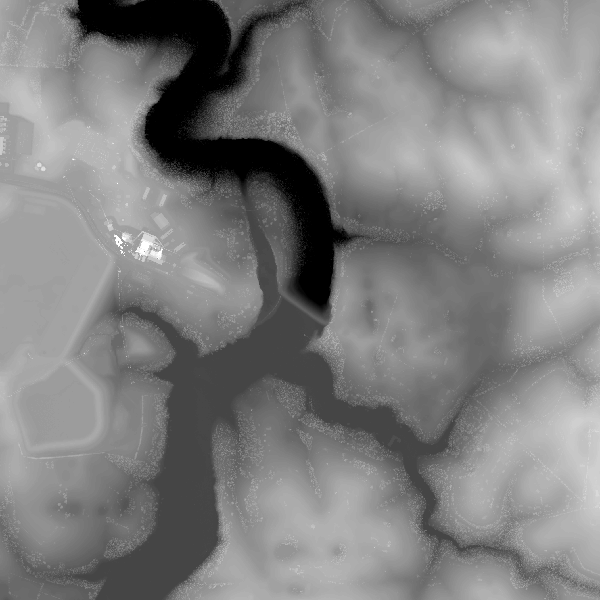

In [58]:
################### EDIT ################### 
# 
# Set AOI
#
# Define the variables
lat = 37.7860232
lon = -84.7040941
dist = '1 Mile' # 1 mile buffer
output = 'herrington_dam_1mi'

# Make function call
makeAoi(lat, lon, dist, output)

# Extract DSM
dsm = 'https://kyraster.ky.gov/arcgis/rest/services/ElevationServices/Ky_DSM_First_Return_5FT_Phase1/ImageServer'

surface = arcpy.sa.ExtractByMask(dsm, output)

printComplete()

surface

Cell finished processing 2023-02-02 17:08:21.279766


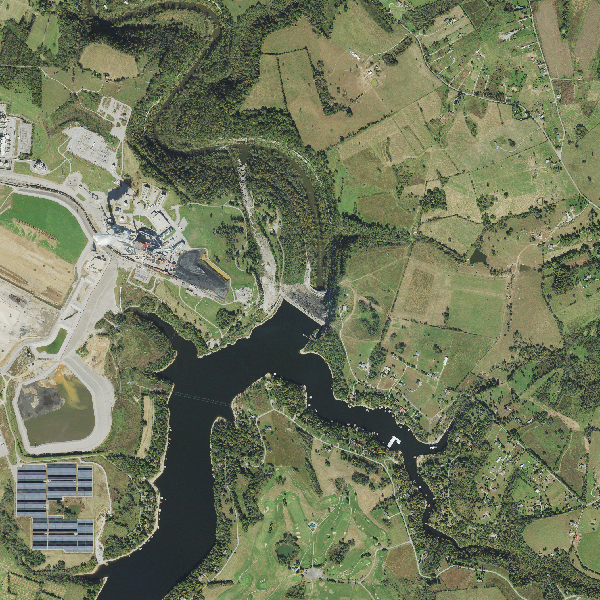

In [59]:
################### EDIT ################### 
# 
# Set aerial photography
#
# Define the variables
naip_photo = 'https://kyraster.ky.gov/arcgis/rest/services/ImageServices/Ky_NAIP_2018_2FT/ImageServer'

naip = arcpy.sa.ExtractByMask(naip_photo, output)

printComplete()

naip

## Hillshade parameters

Relative rates of direct insolation (incoming solar radiation) can be estimated with the hillshade function and its parameter `Model Shadows` set to `True`. 

![Diagram showing relative rate of direct insolation based on slope and shadow](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/solar-00.jpg)
*Diagram showing relative rate of direct insolation based on slope and shadow*

Use the `Azimuth` and `Altitude` parameters to set the sun's position relative to your AOI for a given day of the year. Use at least five different times to compute the relative rate of direct insolation;

1. one hour after sunrise
2. mid-morning 
3. solar noon, the time the sun is highest in the sky
4. mid-afternoon
5. one hour before sunrise.

Use [NOAA Solar Calculator](https://gml.noaa.gov/grad/solcalc/) to find the sun's azimuth and elevation (altitude) for your AOI.

![Find where the sun is in the sky for any day and time for your AOI](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/solar-01.jpg)     
*Find where the sun is in the sky for any day and time for your AOI*

In [60]:
# Calculate five hillshades
#
# Function: Hillshade(in_surface, azimuth, altitude, model_shadows)
t1 = arcpy.sa.Hillshade(surface, 92, 11, True) # one hour after sunrise
t2 = arcpy.sa.Hillshade(surface, 117, 37, True) # mid morning
t3 = arcpy.sa.Hillshade(surface, 180, 57, True) # solar noon (highest elevation of sun)
t4 = arcpy.sa.Hillshade(surface, 240, 37, True) # mid afternoon
t5 = arcpy.sa.Hillshade(surface, 268, 11, True) # one hour before sunset

printComplete()

In [61]:
# Map algebra statement combining relative rates
# Each hillshade cell values are squared because increasing insolation is exponential
#
z = ((t1**2) + (t2**2) + (t3**2) + (t4**2) + (t5**2))**1

In [62]:
# Map Algebra statement to rescale the values to a simple index
# Note that this a classless and unitless scale; it only shows relative rates.
#
z_scaled = ((z/z.maximum)*1000)

In [63]:
# Save raster to our project geodatabase and get statistics for raster. Note mean value.
#
z_scaled.save('solar_scaled')
z_scaled.getStatistics()

[{'min': 0.0, 'max': 1000.0, 'mean': 580.5007730136169, 'standardDeviation': 233.01923747870225, 'skipX': 1, 'skipY': 1, 'count': 0.0}]

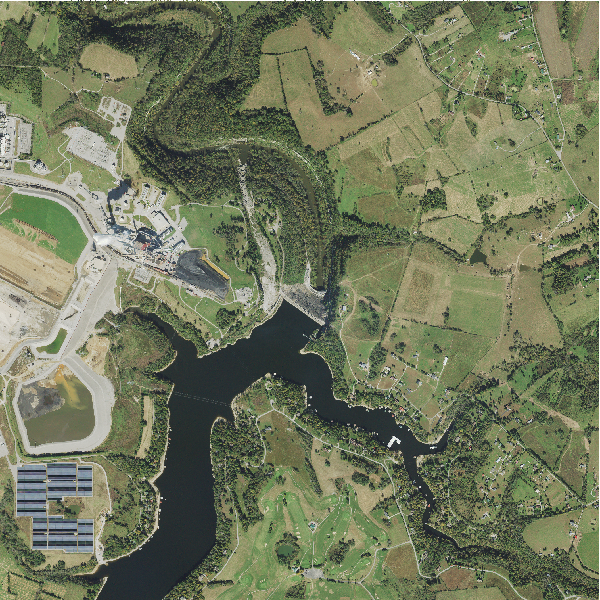

In [64]:
# Extract aerial imagery for AOI
#
a = arcpy.sa.ExtractByMask(naip, z_scaled)

# Verify
a

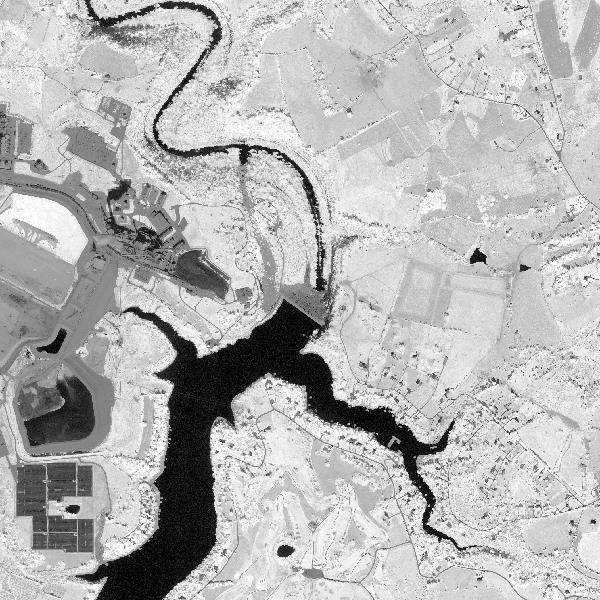

In [65]:
# Create NDVI
#
ndvi = arcpy.ia.NDVI(naip)
ndvi.save('ndvi')

# Verify
ndvi

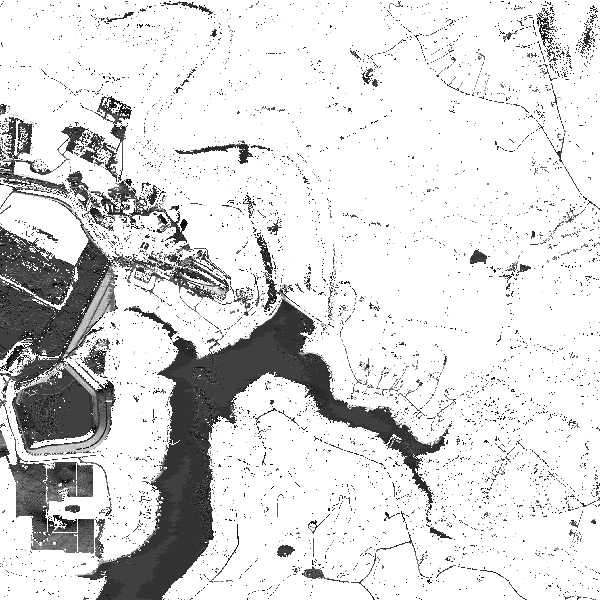

In [66]:
# Create layer for symbology by excluding vegetated surfaces and keeping only areas higher mean relative rate
#
# Get mean value
mean = z_scaled.mean

# Map Algebra statement to exlude vegetative surfaces and keep areas greate than mean rate
solar = arcpy.sa.Con(((ndvi < 0) & (z_scaled >= mean)), z_scaled)
solar.save('solar')

# Verify
solar

## Visualization of solar layer

Use only two layers: the solar layer and the NDVI layer for the base map. The NDVI is a good choice because areas of vegetation will be light values and built environment will be dark. This will provide strong contrast for the solar layer in areas of built environment. 

Use a dark-color-to-bright-yellow color gradient for the solar layer and set its Layer Blending mode to `Screen`.

![Layers to use in map](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/solar-02.jpg)     
*Layers to use in map*

Create a map layout and export to a JPG.

![Example map layout](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/solar-03.jpg)     
*Example map layout*

## Addendum: Animate hillshade to visualize sun's movement

This addendum will show how to automate the creation of video frames that show how the sun's illumination of earth's surface changes over the course of day. The tool uses a `for` loop to iterate over a `Hillshade` function and incrementally change the `azimuth` and `altitude` parameters to mimic the sun's movement in the sky. The tool uses [ffmpeg](https://ffmpeg.org/) to assemble the frames and export a format that can be uploaded to YouTube.

![Animation for Lexing, Kentucky](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/solar-10.jpg)
*Animation for Lexing, Kentucky: https://www.youtube.com/watch?v=PYkf_omlMHo*

### Instructions

![Export rectangular area for DSM](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/solar-11.jpg)
*Export rectangular area for DSM*

<hr>

![Close all open maps and scenes](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/solar-12.jpg)
*Close all open maps and scenes*


In [67]:
################### DO NOT EDIT ###################

# Let's see if you have ffmpeg installed

# Location of ffmpeg
ffmpeg = f'{root}\\tools\\ffmpeg\\ffmpeg.exe'

# Check to see if ffmpeg exists
completed = subprocess.run(f'{ffmpeg} -h', shell=True, stdout=subprocess.PIPE)
print(completed.stdout.decode('UTF-8'))

print('Did you get output describing ffmpeg?')

Hyper fast Audio and Video encoder
usage: ffmpeg [options] [[infile options] -i infile]... {[outfile options] outfile}...

Getting help:
    -h      -- print basic options
    -h long -- print more options
    -h full -- print all options (including all format and codec specific options, very long)
    -h type=name -- print all options for the named decoder/encoder/demuxer/muxer/filter/bsf/protocol
    See man ffmpeg for detailed description of the options.

Print help / information / capabilities:
-L                  show license
-h topic            show help
-? topic            show help
-help topic         show help
--help topic        show help
-version            show version
-buildconf          show build configuration
-formats            show available formats
-muxers             show available muxers
-demuxers           show available demuxers
-devices            show available devices
-codecs             show available codecs
-decoders           show available decoders
-encode

In [ ]:
# If you don't have ffmpeg, run this cell once
downloadFfmpeg()

In [68]:
##################### EDIT #####################
# Set sun position and animation properties 
#
# Start azimuth, e.g., east, in degrees
az = 90 

# Start altitude, e.g., horizon, in degrees
al = 0

# Model shadows
sh = True

# Vertical exaggeration to accentuate shadows
vt = 2

# Max elevation of sun in sky in degrees
maxHeight = 57

# Number of frames
frames = 40

# Frames per second, higher values make smooth animation (increase number of frames, too)
frameRate = 4

# Output folder
output = f'{root}\\{project}\\video'

# Input surface model name
dem = 'surface'

printComplete()

Cell finished processing 2023-02-02 17:20:34.586270


In [69]:
################### DO NOT EDIT ###################
# Create animation frames 
#
completed = subprocess.run(f'mkdir {output}', shell=True, stdout=subprocess.PIPE)
print(completed.stdout.decode('UTF-8'))
i = 0
while i < frames:
    if i < 10:
        f = f'00{i}'
    elif i < 100:
        f = f'0{i}'
    else:
        f = i
    arcpy.HillShade_3d(dem, f'{output}\\img{f}.tif', az, al, sh, vt)
    arcpy.management.CopyRaster(f'{output}\\img{f}.tif', f'{output}\\img{f}.jpg', "#","#", "#", "#", "#", "8_BIT_UNSIGNED", "#", "#", "JPEG")
    arcpy.Delete_management(f'{output}\\img{f}.tif')
    if i < frames/2:
        az += 90/(frames/2)
        al += maxHeight/(frames/2)
        print(f'Frame: {f} || Altitude: {int(al)} || Azimuth: {int(az)}')
    if i >= frames/2:
        az += 90/(frames/2)
        al -= maxHeight/(frames/2)
        print(f'Frame: {f} || Altitude: {int(al)} || Azimuth: {int(az)}')
    i += 1
printComplete()


Frame: 000 || Altitude: 2 || Azimuth: 94
Frame: 001 || Altitude: 5 || Azimuth: 99
Frame: 002 || Altitude: 8 || Azimuth: 103
Frame: 003 || Altitude: 11 || Azimuth: 108
Frame: 004 || Altitude: 14 || Azimuth: 112
Frame: 005 || Altitude: 17 || Azimuth: 117
Frame: 006 || Altitude: 19 || Azimuth: 121
Frame: 007 || Altitude: 22 || Azimuth: 126
Frame: 008 || Altitude: 25 || Azimuth: 130
Frame: 009 || Altitude: 28 || Azimuth: 135
Frame: 010 || Altitude: 31 || Azimuth: 139
Frame: 011 || Altitude: 34 || Azimuth: 144
Frame: 012 || Altitude: 37 || Azimuth: 148
Frame: 013 || Altitude: 39 || Azimuth: 153
Frame: 014 || Altitude: 42 || Azimuth: 157
Frame: 015 || Altitude: 45 || Azimuth: 162
Frame: 016 || Altitude: 48 || Azimuth: 166
Frame: 017 || Altitude: 51 || Azimuth: 171
Frame: 018 || Altitude: 54 || Azimuth: 175
Frame: 019 || Altitude: 57 || Azimuth: 180
Frame: 020 || Altitude: 54 || Azimuth: 184
Frame: 021 || Altitude: 51 || Azimuth: 189
Frame: 022 || Altitude: 48 || Azimuth: 193
Frame: 023 || A

In [70]:
################### DO NOT EDIT ###################
# Delete existing animation 
completed = subprocess.run(f'del {output}\\hillshade-animation.mp4', shell=True, stdout=subprocess.PIPE)
print(completed.stdout.decode('UTF-8'))

# Create animation
completed = subprocess.run(f'{ffmpeg} -framerate {frameRate} -i {output}\\img%03d.jpg -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" {output}\\hillshade-animation.mp4', shell=True, stdout=subprocess.PIPE)
print(completed.stdout.decode('UTF-8'))
printComplete()



Cell finished processing 2023-02-02 17:25:07.333269


In [71]:
# Stop! Run this cell to see if we can make an animated GIF.
# It may work, depending on how large the source video is.
################### DO NOT EDIT ###################
# Delete existing gif
completed = subprocess.run(f'del {output}\\hillshade-animation.gif', shell=True, stdout=subprocess.PIPE)
print(completed.stdout.decode('UTF-8'))

# Create animation
completed = subprocess.run(f'{ffmpeg} -i {output}\\hillshade-animation.mp4 -f {output}\\hillshade-animation.gif', shell=True, stdout=subprocess.PIPE)
print(completed.stdout.decode('UTF-8'))
printComplete()



Cell finished processing 2023-02-02 17:26:28.172771
